In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models  import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ,LearningRateScheduler,TensorBoard
from wordcloud import WordCloud

%matplotlib inline


In [6]:
import os

In [21]:
INPUT_DIR=os.path.join("..", "artifacts", "raw")

In [22]:
# First, let's check what columns are in the file
df_columns = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv"), nrows=0)
print("Columns in the file:")
print(df_columns.columns.tolist())

Columns in the file:
['user_id', 'anime_id', 'rating', 'watching_status', 'watched_episodes']


In [23]:
rating_df = pd.read_csv(
    os.path.join(INPUT_DIR, "animelist.csv"),
    low_memory=True, 
    usecols=['user_id', 'anime_id', 'rating']  # Updated column names
)

In [51]:
rating_df.head(5)

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [25]:
len(rating_df)

5000000

# DATA PROCESSING

In [26]:
n_rating=rating_df['user_id'].value_counts()

In [27]:
n_rating

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [28]:
rating_df=rating_df[rating_df['user_id'].isin(n_rating[n_rating > 400].index)].copy()

In [29]:
len(rating_df)

3242641

In [33]:
max_rating=rating_df['rating'].max()
min_rating=rating_df['rating'].min()
average_rating=rating_df['rating'].mean()

In [34]:
average_rating

np.float64(0.41220239921718105)

rating_df["rating"] = rating_df["rating"].apply(lambda x : (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [35]:
max_rating

np.float64(1.0)

In [36]:
min_rating

np.float64(0.0)

In [37]:
rating_df.duplicated().sum()

np.int64(0)

In [38]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [39]:
user_ids=rating_df['user_id'].unique().tolist()

In [43]:
user2user_encoded={user_id: i for i, user_id in enumerate(user_ids)}

In [44]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [46]:
user2user_decoded={i: user_id for i, user_id in enumerate(user_ids)}
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [47]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [48]:
rating_df.head(10)

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
218,2,5042,0.8,0
219,2,7593,0.8,0
220,2,21,0.9,0
221,2,35446,0.0,0
222,2,24,0.0,0


In [49]:
n_users=len(user2user_encoded)

In [50]:
n_users

4193

In [53]:
anime_ids=rating_df['anime_id'].unique().tolist()
anime2anime_encoded={anime_id: i for i, anime_id in enumerate(anime_ids)}
anime2anime_encoded 
   

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [54]:
anime2anime_decoded={i: anime_id for i, anime_id in enumerate(anime_ids)}
anime2anime_decoded  

{0: 24833,
 1: 235,
 2: 36721,
 3: 40956,
 4: 31933,
 5: 5042,
 6: 7593,
 7: 21,
 8: 35446,
 9: 24,
 10: 22,
 11: 38034,
 12: 17251,
 13: 5762,
 14: 31580,
 15: 33253,
 16: 35028,
 17: 9513,
 18: 368,
 19: 11633,
 20: 31964,
 21: 33486,
 22: 31740,
 23: 1470,
 24: 1575,
 25: 2904,
 26: 1535,
 27: 28223,
 28: 226,
 29: 38671,
 30: 32872,
 31: 15,
 32: 71,
 33: 7661,
 34: 245,
 35: 263,
 36: 5258,
 37: 270,
 38: 24703,
 39: 15451,
 40: 8074,
 41: 11061,
 42: 28961,
 43: 34542,
 44: 14719,
 45: 20899,
 46: 26055,
 47: 34933,
 48: 37086,
 49: 1604,
 50: 22535,
 51: 189,
 52: 34599,
 53: 29575,
 54: 10620,
 55: 32182,
 56: 23755,
 57: 20,
 58: 1735,
 59: 35581,
 60: 5040,
 61: 30276,
 62: 34134,
 63: 6893,
 64: 11499,
 65: 29786,
 66: 16498,
 67: 28171,
 68: 32282,
 69: 9253,
 70: 3455,
 71: 22319,
 72: 10851,
 73: 40658,
 74: 29809,
 75: 25397,
 76: 2852,
 77: 1635,
 78: 1636,
 79: 40337,
 80: 39085,
 81: 857,
 82: 9721,
 83: 36625,
 84: 6987,
 85: 8577,
 86: 9849,
 87: 4010,
 88: 16642,
 

In [56]:
rating_df["anime_id"] = rating_df["anime_id"].map(anime2anime_encoded)

In [57]:
rating_df.head(5)

,user_id,anime_id,rating,user
213,2,0,0.0,0
214,2,1,1.0,0
215,2,2,0.0,0
216,2,3,0.0,0
217,2,4,0.0,0


In [58]:
n_anime=len(anime2anime_encoded)

In [59]:
n_anime

17149

In [60]:
rating_df=rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [61]:
rating_df

,user_id,anime_id,rating,user
0,1177,1494,0.7,319
1,5552,5821,0.7,1368
2,10777,2349,0.7,2692
3,4773,6142,0.6,1164
4,1833,3136,0.9,472
...,...,...,...,...
3242636,7928,3188,0.0,2002
3242637,7522,193,0.9,1896
3242638,12688,405,0.7,3201
3242639,8408,563,0.7,2112


In [62]:
X = rating_df[["user", "anime_id"]].values
y = rating_df["rating"]

In [63]:
test_size = 1000

In [64]:
train_indices = rating_df.shape[0] - test_size

In [65]:
X_train , y_train , X_test, y_test = X[:train_indices], y[:train_indices], X[train_indices:], y[train_indices:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3241641, 2), (3241641,), (1000, 2), (1000,))

In [66]:
type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray,
 pandas.core.series.Series,
 numpy.ndarray,
 pandas.core.series.Series)

In [67]:
X_train_array= [X_train[:,0], X_train[:,1]]
X_test_array= [X_test[:,0], X_test[:,1]]    

In [68]:
type(X_train_array), type(y_train), type(X_test_array), type(y_test)

(list, pandas.core.series.Series, list, pandas.core.series.Series)

In [75]:
### Model architecture ###

def RecommenderNet():
    embedding_size=128
    user =Input(name='user', shape=[1])
    user_embedding = Embedding(input_dim=n_users,  name='user_embedding', output_dim=embedding_size)(user)
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(input_dim=n_anime, name='anime_embedding', output_dim=embedding_size)(anime)
    x= Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    x= Flatten()(x) 
    x=Dense(1,kernel_initializer='he_normal')(x)
    x=Activation('sigmoid')(x)
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['mae', 'mse']
    )
    return model

In [76]:
model=RecommenderNet()


In [77]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    536,704 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ dense_2[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,731,778 (10.42 MB)

 Trainable params: 2,731,778 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
start_lr=0.00001
min_lr=0.0001
max_lr=0.00005
batch_size=10000

ramup_epochs=5
sustain_epochs=0
exp_decay=0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr   
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr


In [82]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
checkpoint_filepath= './weights.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)




In [83]:
earlystopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [84]:
my_callbacks = [model_checkpoint_callback , lr_callback, earlystopping_callback]

In [85]:
model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=my_callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - loss: 0.6942 - mae: 0.3616 - mse: 0.1563 - val_loss: 0.6940 - val_mae: 0.3609 - val_mse: 0.1558 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - loss: 0.6937 - mae: 0.3613 - mse: 0.1559 - val_loss: 0.6936 - val_mae: 0.3609 - val_mse: 0.1556 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - loss: 0.6928 - mae: 0.3610 - mse: 0.1555 - val_loss: 0.6930 - val_mae: 0.3609 - val_mse: 0.1553 - learning_rate: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 0.6917 - mae: 0.3606 - mse: 0.1548 - val_loss: 0.6923 - val_mae: 0.3609 - val_mse: 0.1549 -

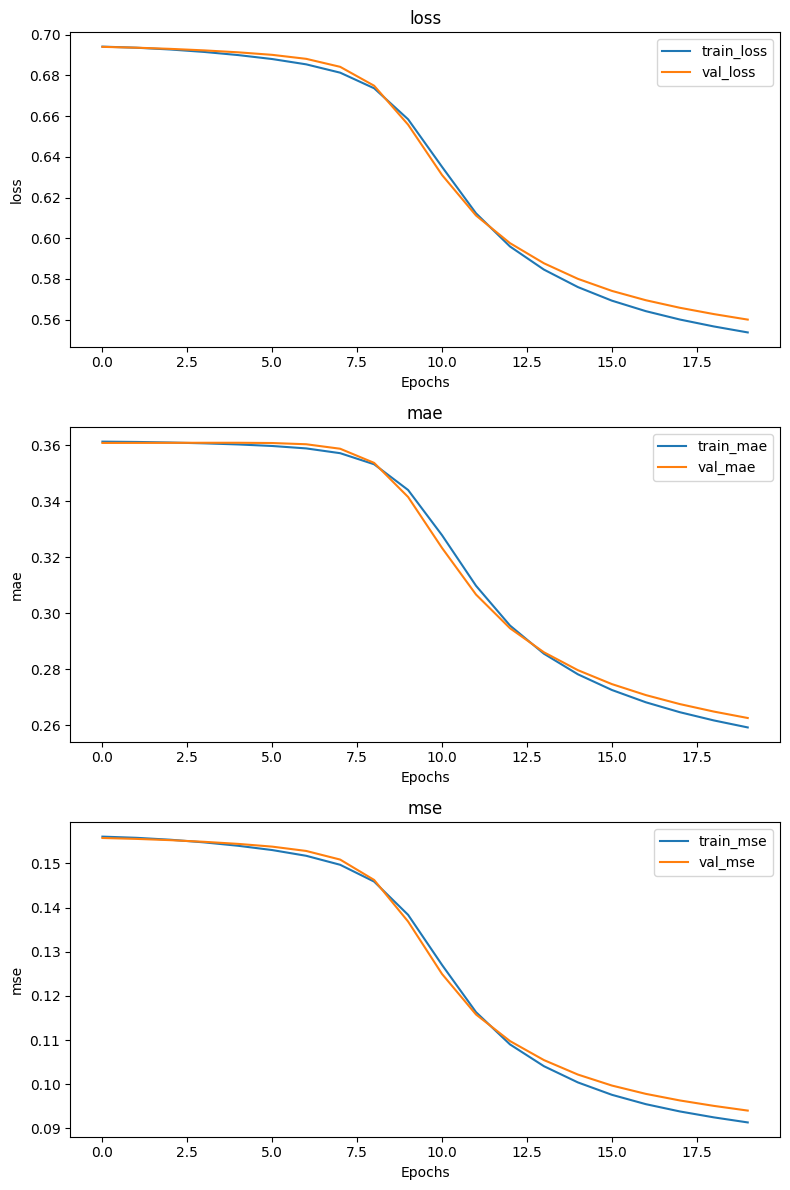

In [86]:
metrics = ["loss", "mae", "mse"]
fig , axes = plt.subplots(len (metrics) , 1, figsize=(8, len(metrics)*4))
for i, metric in enumerate(metrics):
    axes[i].plot(model.history.history[metric], label='train_' + metric)
    axes[i].plot(model.history.history['val_' + metric], label='val_' + metric)
    axes[i].legend()
    axes[i].set_title(metric)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()


In [87]:
def extrcat_weights(model , name):
    weights = model.get_layer(name).get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape(-1, 1)
    return weights

    

In [88]:
anime_weights = extrcat_weights(model, 'anime_embedding')
user_weights = extrcat_weights(model, 'user_embedding')

In [90]:
### Reading anime.csv file ###
df= pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [92]:
df = df.replace("Unknown", np.nan)

In [93]:
def  getAnimeName(anime_id):
    try:
        name=df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name=df[df.anime_id == anime_id].name.values[0]
    except:
        print("KeyError: ", anime_id)
    return name            
        
        

In [98]:
df ["anime_id"] = df ["MAL_ID"] 
df["eng_version"]= df["English name"]
df["eng_version"]=df.anime_id.apply(lambda x: getAnimeName(x))

KeyError:  15
KeyError:  17
KeyError:  18
KeyError:  23
KeyError:  29
KeyError:  54
KeyError:  55
KeyError:  56
KeyError:  69
KeyError:  83
KeyError:  94
KeyError:  102
KeyError:  110
KeyError:  115
KeyError:  117
KeyError:  118
KeyError:  119
KeyError:  126
KeyError:  127
KeyError:  128
KeyError:  137
KeyError:  138
KeyError:  139
KeyError:  142
KeyError:  144
KeyError:  151
KeyError:  152
KeyError:  163
KeyError:  171
KeyError:  173
KeyError:  176
KeyError:  179
KeyError:  181
KeyError:  183
KeyError:  184
KeyError:  187
KeyError:  197
KeyError:  203
KeyError:  204
KeyError:  211
KeyError:  212
KeyError:  215
KeyError:  221
KeyError:  222
KeyError:  233
KeyError:  234
KeyError:  252
KeyError:  255
KeyError:  258
KeyError:  259
KeyError:  260
KeyError:  261
KeyError:  262
KeyError:  265
KeyError:  271
KeyError:  278
KeyError:  281
KeyError:  282
KeyError:  284
KeyError:  285
KeyError:  286
KeyError:  287
KeyError:  293
KeyError:  294
KeyError:  301
KeyError:  305
KeyError:  308
KeyErr

In [ ]:
df ["anime_id"] = df ["MAL_ID"] 